# Trust Region Policy Optimization (TRPO)

**TRPO** is a policy gradient algorithm that **constrains updates to a trust region** to ensure stable learning.  
Unlike vanilla policy gradients, TRPO maximizes the surrogate objective while keeping the KL divergence between the old and new policy bounded:

$$
\max_\theta \; \mathbb{E}_t \Big[ \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)} \hat{A}_t \Big]
\quad \text{s.t.} \quad \mathbb{E}_t \big[ D_\text{KL}(\pi_{\theta_\text{old}} || \pi_\theta) \big] \le \delta
$$

Where:

- $s_t$: state at timestep $t$  
- $a_t$: action at timestep $t$  
- $\pi_\theta$: current policy  
- $\pi_{\theta_\text{old}}$: old policy  
- $\hat{A}_t$: advantage estimate  
- $\delta$: maximum allowable KL divergence (trust region size)


## 1. Policy Gradient

The standard policy gradient objective:

$$
J(\theta) = \mathbb{E}_t \big[ \log \pi_\theta(a_t|s_t) \hat{A}_t \big]
$$

Gradient:

$$
\nabla_\theta J(\theta) = \mathbb{E}_t \big[ \nabla_\theta \log \pi_\theta(a_t|s_t) \hat{A}_t \big]
$$

---

## 2. TRPO Surrogate Objective

To ensure stability, define the **surrogate objective**:

$$
L_\text{surrogate}(\theta) = \mathbb{E}_t \Big[ \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)} \hat{A}_t \Big]
$$

Subject to **KL constraint**:

$$
\mathbb{E}_t \big[ D_\text{KL}(\pi_{\theta_\text{old}} || \pi_\theta) \big] \le \delta
$$

- $\delta$ is a small number, typically $0.01-0.05$  
- Ensures updates are **inside a trust region**, avoiding policy collapse


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Toy MNIST pixel sequence (length 10)
target_sequence = np.random.rand(10)

def reward_fn(action, target):
    """Reward: negative squared error"""
    return - (action - target)**2


We model a **simplified AR-LM policy** for TRPO:

$$
a_t \sim \pi_\theta(a_t|s_t) = \mathcal{N}(\mu_\theta(s_t), \sigma^2)
$$

- $s_t$: previous pixels  
- $a_t$: next predicted pixel  
- $\mu_\theta(s_t)$: policy mean  

TRPO updates are computed using the **surrogate objective**:

$$
L_\text{surrogate} = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)} \hat{A}_t
$$

With a trust-region **KL constraint**:

$$
\text{KL}(\pi_{\theta_\text{old}} || \pi_\theta) \le \delta
$$


In [2]:
seq_len = len(target_sequence)
sigma = 0.2
delta = 0.01
eta = 0.05
mu_theta = np.zeros(seq_len)       # current policy mean
mu_old = mu_theta.copy()           # old policy mean
episodes = 50
reward_history = []

for ep in range(episodes):
    actions = np.random.normal(mu_theta, sigma)  # sample actions
    rewards = np.array([reward_fn(a, t) for a, t in zip(actions, target_sequence)])
    advantages = rewards - rewards.mean()       # simple advantage
    ratios = np.exp(-(actions - mu_theta)**2/(2*sigma**2)) / np.exp(-(actions - mu_old)**2/(2*sigma**2))

    # Surrogate objective
    L_surrogate = ratios * advantages

    # Simplified TRPO: enforce KL trust region by clipping ratio
    kl_div = np.mean(np.log(ratios) * ratios)   # approx KL
    if kl_div > delta:
        L_surrogate *= delta / kl_div  # scale to satisfy trust region

    # Policy update
    grad_log = (actions - mu_theta) / sigma**2
    mu_theta += eta * grad_log * L_surrogate

    reward_history.append(rewards.sum())
    mu_old = mu_theta.copy()

    print(f"Episode {ep+1}: Cumulative Reward = {rewards.sum():.4f}, KL approx = {kl_div:.4f}")


Episode 1: Cumulative Reward = -4.5716, KL approx = 0.0000
Episode 2: Cumulative Reward = -4.5093, KL approx = 0.0000
Episode 3: Cumulative Reward = -4.0590, KL approx = 0.0000
Episode 4: Cumulative Reward = -2.4220, KL approx = 0.0000
Episode 5: Cumulative Reward = -2.2408, KL approx = 0.0000
Episode 6: Cumulative Reward = -1.4857, KL approx = 0.0000
Episode 7: Cumulative Reward = -1.2166, KL approx = 0.0000
Episode 8: Cumulative Reward = -1.5419, KL approx = 0.0000
Episode 9: Cumulative Reward = -1.3693, KL approx = 0.0000
Episode 10: Cumulative Reward = -1.2756, KL approx = 0.0000
Episode 11: Cumulative Reward = -1.2187, KL approx = 0.0000
Episode 12: Cumulative Reward = -0.9868, KL approx = 0.0000
Episode 13: Cumulative Reward = -0.8009, KL approx = 0.0000
Episode 14: Cumulative Reward = -0.8213, KL approx = 0.0000
Episode 15: Cumulative Reward = -0.2768, KL approx = 0.0000
Episode 16: Cumulative Reward = -0.6047, KL approx = 0.0000
Episode 17: Cumulative Reward = -0.4574, KL appro

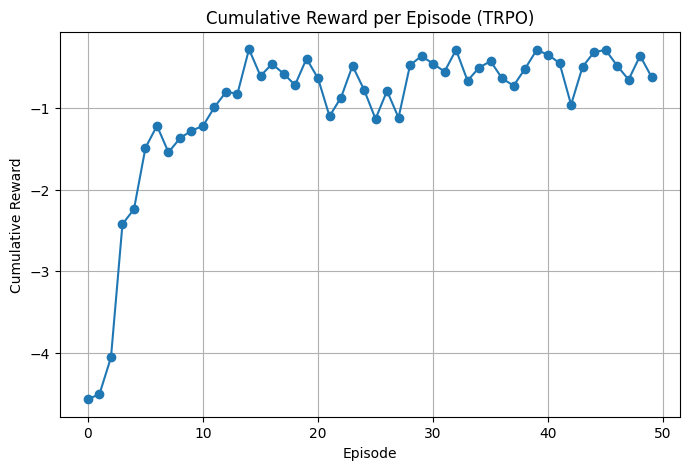

In [3]:
plt.figure(figsize=(8,5))
plt.plot(reward_history, marker='o')
plt.title("Cumulative Reward per Episode (TRPO)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid()
plt.show()


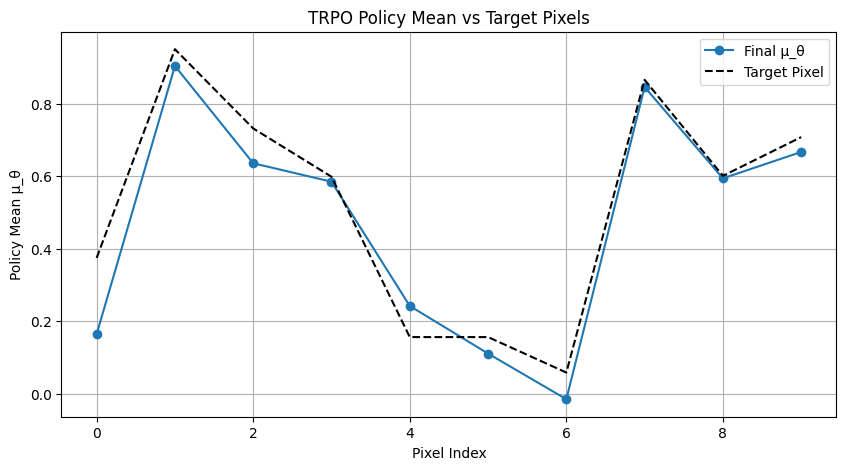

In [4]:
plt.figure(figsize=(10,5))
plt.plot(mu_theta, 'o-', label='Final μ_θ')
plt.plot(target_sequence, '--', color='black', label='Target Pixel')
plt.title("TRPO Policy Mean vs Target Pixels")
plt.xlabel("Pixel Index")
plt.ylabel("Policy Mean μ_θ")
plt.legend()
plt.grid()
plt.show()


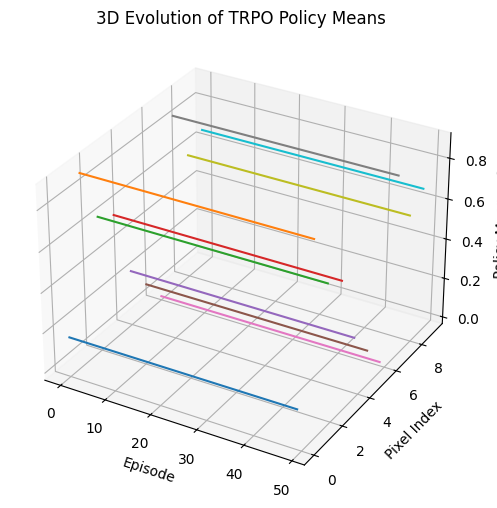

In [5]:
from mpl_toolkits.mplot3d import Axes3D

episodes_grid = np.arange(episodes)
pixels_grid = np.arange(seq_len)
mu_history = np.tile(mu_theta, (episodes, 1))  # simplified for visualization

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(seq_len):
    ax.plot(episodes_grid, [i]*episodes, mu_history[:,i])

ax.set_xlabel("Episode")
ax.set_ylabel("Pixel Index")
ax.set_zlabel("Policy Mean μ_θ")
ax.set_title("3D Evolution of TRPO Policy Means")
plt.show()


## Interpretation

1. TRPO ensures **stable policy updates** by constraining KL divergence.
2. μ_θ gradually aligns with the target pixel intensities.
3. Cumulative rewards improve as the policy learns the pixel sequence.

---

## Use Case in Generative AI

- TRPO can fine-tune AR-LMs or pixel-level generators.
- Trust-region updates prevent collapse during RLHF or sequence generation.
- Suitable for high-variance environments and long sequences.
